In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_regression_pipelines, categorical_input_columns, pipelines 
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import view_as_exponential

In [2]:
load_process_and_store_spreadsheets()

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

We would like to make a prediction model that, given certain input $x$, generates a prediction $y$. In the case at hand, $y$ would be the overall survival (OS) or the progression free survival (PFS). In a perfect scenario, there is no noise in the data and we can predict with certainty the outcome. That is,
$f(x) $
and our goal is to design a function $g(x)$ that is a good approximation of $f(x)$. In reality, we have incomplete knowledge, and this lack of knowledge introduces noise in the data. Therefore, in practice one has
$$
y = f(x) + \epsilon,$$
with $\epsilon$ some noise term. Given a sufficiently large population of patients, it is always possible to detect the effect of $x$ on $y$, no matter the scale of the random contribution $\epsilon$. When, however, we are talking about single instances rather than populations this changes. It will be dificult to discern signal from noise when the signal to noise ratio is of order unity or below.


TODO:
- Calculate half life $\tau$ for each combination of phenotypes. 
- Compare differences in half life $\Delta \tau$ to variance in $t$ as $\Delta \tau/ \sigma_t$ to quantify signal.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 ,
$$
with $\langle t \rangle = 1/\alpha$ and $\langle t^2 \rangle= 2/\alpha^2$. This gives:
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$

In [3]:
# Also the combined:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
non_resp = y['response_grouped'] == 'non responder (sd+pd)'
y_non_resp = y[non_resp]
y_resp = y[~non_resp]

In [4]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']

If the the distribution $p(t)$ is exponentially decreasing $\propto \exp(-\alpha t)$ then necessarily
$$
P(t^\prime) = c\int_{0}^{t^\prime} \mathrm{d}t \exp(-\alpha t) = \frac{-c}{\alpha} \left( e^{-\alpha t^\prime} - 1 \right).
$$

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
X = MergeRareCategories(thresshold=40, categorical_columns=categorical_input_columns).fit_transform(X)

** gender **
            tau  sigma_t    n         r
all     216.837  305.877  125 -0.950032
male    226.781  307.094   70 -0.975415
female  268.355  303.974   55 -0.995173
                signal  signal to noise
male-female  41.573833         0.135917
--------------------
** stage **
         tau  sigma_t    n         r
all  216.837  305.877  125 -0.950032
4    228.295  314.694  109 -0.943583
3    300.838  232.724   16 -0.971683
        signal  signal to noise
4-3  72.542822         0.237163
--------------------
** therapyline **
             tau  sigma_t    n         r
all      216.837  305.877  125 -0.950032
2        280.016  309.764   83 -0.997873
1+3+0+4  245.406  293.996   42 -0.990076
              signal  signal to noise
2-1+3+0+4  34.609658         0.113149
--------------------
** smokingstatus **
                                 tau  sigma_t    n         r
all                          216.837  305.877  125 -0.950032
smoker                       329.657  340.062   75 -0.997976

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  func(*args, **kwargs)


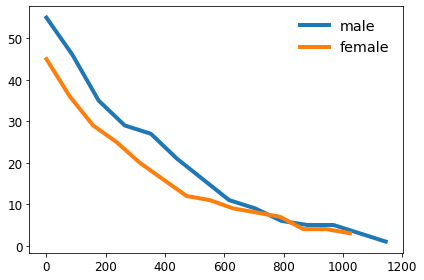

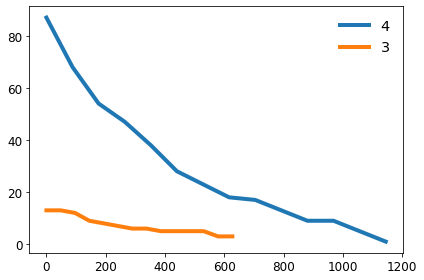

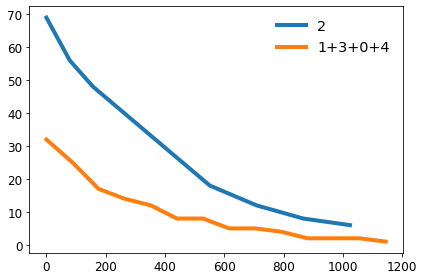

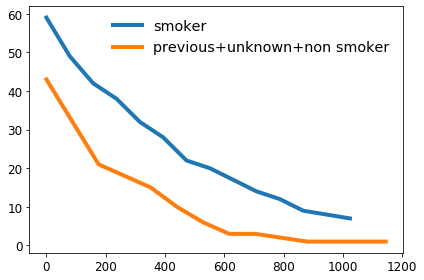

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


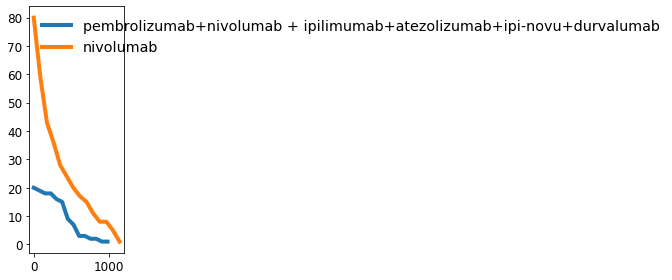

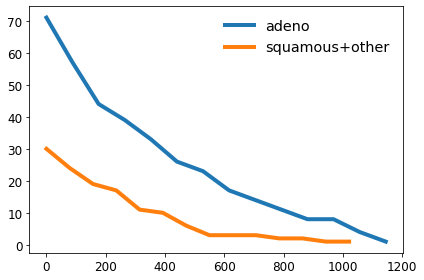

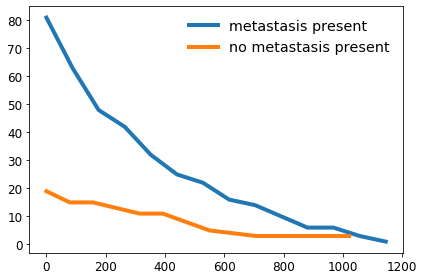

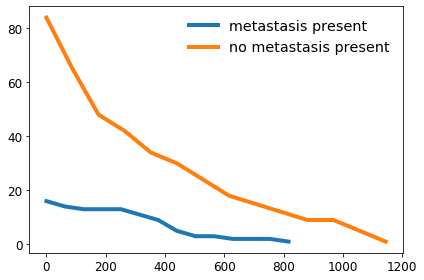

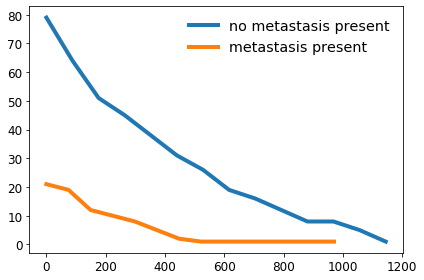

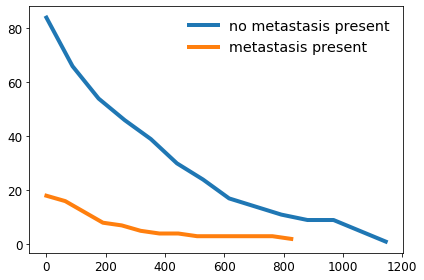

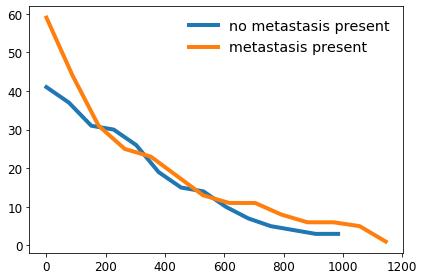

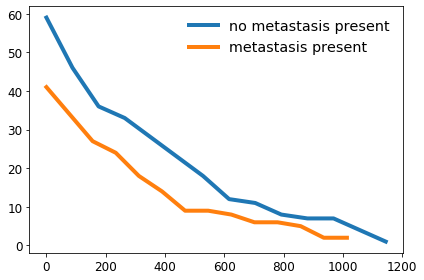

In [7]:
for category in categorical_input_columns:
    plt.figure()
    df = fit_categorical_survival(X[category], y['OS_days'], plot='cdf')
    print('**',category, '**')
    print(df)
    s = categorical_signal(df)
    print(s)
    print('--'*10)

In [8]:
from fit import categorical_signal_summary

In [9]:
categorical_signal_summary(X, y['OS_days'], categorical_input_columns)

,,signal,signal to noise
category,item,,
gender,male-female,41.573833,0.135917
stage,4-3,72.542822,0.237163
therapyline,2-1+3+0+4,34.609658,0.113149
smokingstatus,smoker-previous+unknown+non smoker,143.430552,0.468916
Systemischetherapie,pembrolizumab+nivolumab + ipilimumab+atezolizumab+ipi-novu+durvalumab-nivolumab,40.112911,0.131141
histology_grouped,adeno-squamous+other,36.051909,0.117864
lymfmeta,metastasis present-no metastasis present,111.699710,0.365178
brainmeta,metastasis present-no metastasis present,33.175529,0.108460
adrenalmeta,no metastasis present-metastasis present,41.995421,0.137295


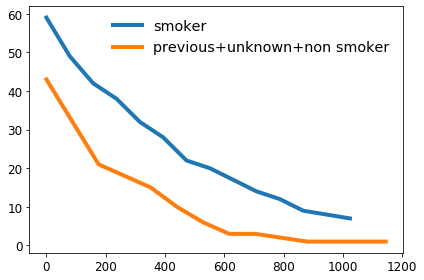

In [10]:
df = fit_categorical_survival(X['smokingstatus'], y['OS_days'], plot='cdf')
# df = fit_categorical_survival(X['gender'], y['OS_days'])

In [11]:
categorical_signal(df).T

,smoker-previous+unknown+non smoker
signal,143.430552
signal to noise,0.468916


## Categorical plots

In [12]:
X['Systemischetherapie'].value_counts()

nivolumab                                                                103
pembrolizumab+nivolumab + ipilimumab+atezolizumab+ipi-novu+durvalumab     22
Name: Systemischetherapie, dtype: int64

In [13]:
# X['smokingstatus']
y['OS_days']

Patient ID
7118    611.0
7073     44.0
1023    889.0
7155    462.0
7027    836.0
        ...  
7184    350.0
1119    546.0
1024    184.0
1057    294.0
7135    188.0
Name: OS_days, Length: 125, dtype: float64

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


<Figure size 432x288 with 0 Axes>

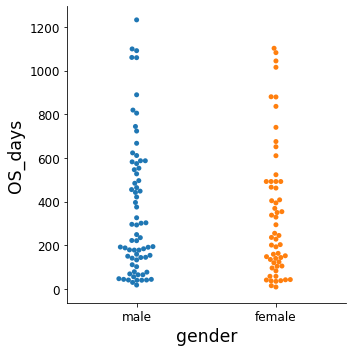

<Figure size 432x288 with 0 Axes>

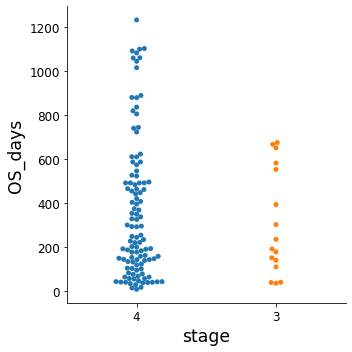

<Figure size 432x288 with 0 Axes>

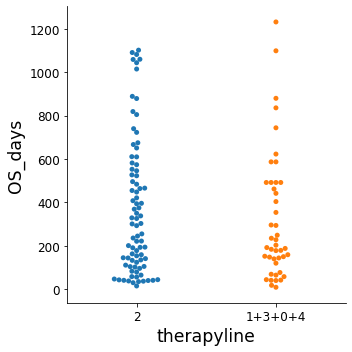

<Figure size 432x288 with 0 Axes>

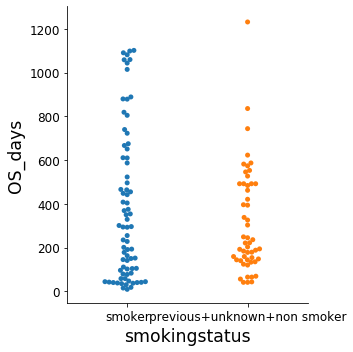

<Figure size 432x288 with 0 Axes>

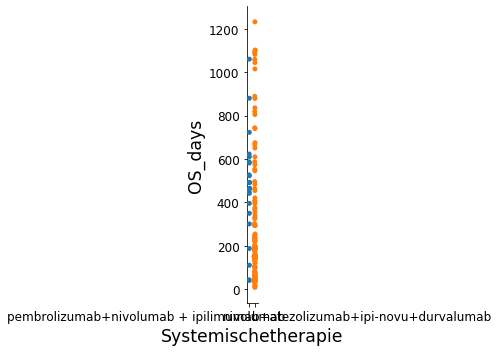

<Figure size 432x288 with 0 Axes>

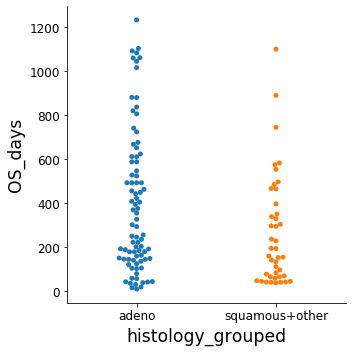

<Figure size 432x288 with 0 Axes>

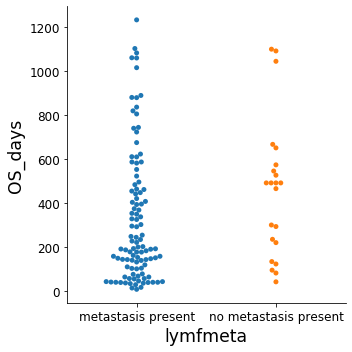

<Figure size 432x288 with 0 Axes>

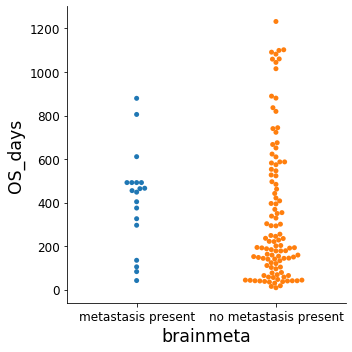

<Figure size 432x288 with 0 Axes>

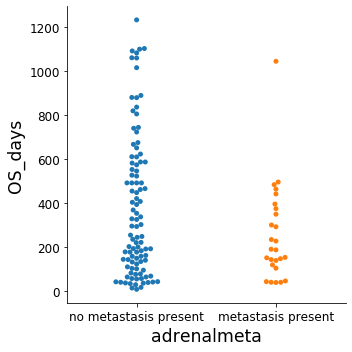

<Figure size 432x288 with 0 Axes>

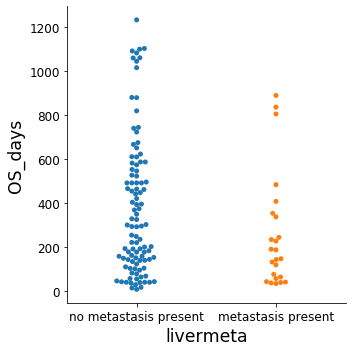

<Figure size 432x288 with 0 Axes>

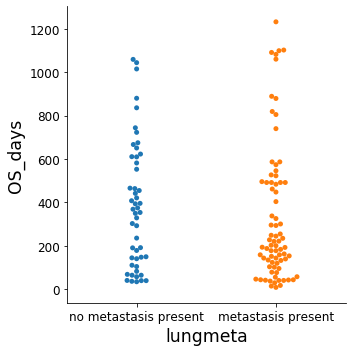

<Figure size 432x288 with 0 Axes>

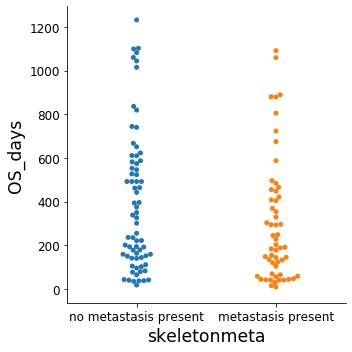

In [15]:
for category in categorical_input_columns:
    plt.figure()
    M = pd.merge(y['OS_days'], X[category], on='Patient ID')
    sns.catplot(y='OS_days', x=category, kind='swarm', data=M)

# Overall survival

In [16]:
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'])

In [17]:
# f = lambda x: np.log(x)**2
# y_smoker = y[X['smokingstatus'] == 'smoker']
# sns.distplot(f(y['OS_days']))
# plt.figure()
# sns.distplot(f(y_smoker['OS_days']))
# plt.figure()
# sns.distplot(f(y[X['smokingstatus'] != 'smoker']['OS_days']))

## Decay rate

Text(0, 0.5, '$n$')

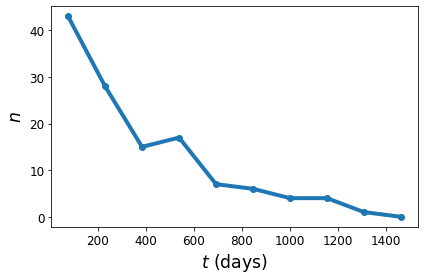

In [18]:
plt.plot(t_OS, p_OS, '-o')
plt.xlabel('$t$ (days)')
plt.ylabel('$n$')

If patients decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$


Fit line to the data

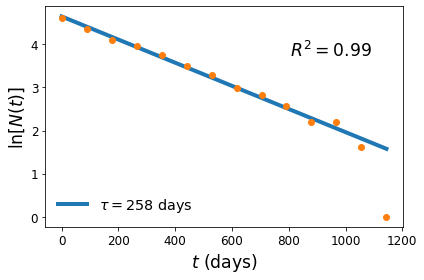

In [19]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers)

# Progression free survival

In [20]:
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'])

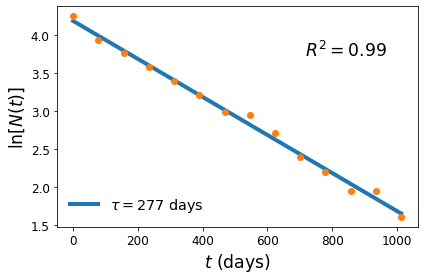

In [21]:
view_as_exponential(t_PFS_cum, p_PFS_cum)

In [22]:
ps = build_regression_pipelines()
rmse = lambda a, b: mean_squared_error(np.exp(a), np.exp(b), multioutput='raw_values')**0.5
b = benchmark_pipelines(ps, X_train, np.log(y_train_pfs), X_test, np.log(y_test_pfs), metric=rmse)
# Root mean squared error.
# b = b**0.5

In [23]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,[333.18033619785456],[304.215258506108],[312.1689888827248],[312.6622257330847]
RandomForestRegressor,[300.4414246762555],[302.4467741012404],[287.8389862727065],[299.1975683597893]
GradientBoostingRegressor,[298.60102649483736],[300.9137320503711],[292.76151703326013],[298.8710947749606]
KNeighborsRegressor,[338.8618868416037],[303.9760861986667],[325.28836816245104],[312.01122401629647]
ElasticNet,[298.4255657855878],[298.5516487844678],[298.4255657855878],[298.48872069330866]
LinearRegression,[303.54996419248283],[317.756135285355],[1.609420894540543e+73],[286.9170922023343]
SVR,[293.02976543301094],[299.5941698035811],[293.0940126151317],[296.4765278562311]
DummyRegressor,[298.722543331997],[298.722543331997],[298.722543331997],[298.722543331997]


## Multitask elastic net

In [24]:
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [25]:
Y_train = np.log(y_train[['OS_days', 'PFS_days']])
Y_test = np.log(y_test[['OS_days', 'PFS_days']])
# Y_train = y_train[['OS_days', 'PFS_days']]
# Y_test = y_test[['OS_days', 'PFS_days']]

# rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
rmse = lambda a, b: mean_squared_error(np.exp(a), np.exp(b), multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)

,Freeman_test,Julian_test,Richard_test
bla,"[279.74023142566193, 296.4768389833383]","[282.2369780258766, 298.5516487844678]","[279.74023142566193, 296.4768389833383]"
